# Z01.4: Token Propensities Analysis


This notebook contains the analysis of Token Propensities. This is the second analysis of first Scribal Intent Study (Z01).

## Setup and Utility Functions

In [1]:
# Imports and setup
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import os

from qlynx.file_utils import load_pkl, store_pkl
from qlynx.stats_utils import *
from qlynx.display_utils import render_html_to_image
from voynichlib.utils import display_voynichese

%reload_ext autoreload
%autoreload 2
 

# Set Global Parameters

In [2]:
do_parametric_studies = True
MAX_BAYES = np.exp(10)
MAX_PROPENSITY = 999
THRESHOLDS = {
    'p_value': 0.01,
    'ln_bayes_factor': 5
}
THRESHOLDS['bayes_factor'] = np.exp(THRESHOLDS['ln_bayes_factor'])
reference_cohort = 'MIDDLE'
# smooth = 'laplace'
# smooth = 'laplace'
smooth = None



## Load the Token Cohort Data

In [3]:
file_path = 'voynich_data/outputs/token_cohort_data.pkl'
token_cohort_data = load_pkl(file_path)

cohorts = token_cohort_data['cohorts']
cohorts_with_randoms = token_cohort_data['cohorts_with_randoms']

corpus_by_c = token_cohort_data['corpus_by_c']
pmfs_by_c = token_cohort_data['pmfs_by_c']
token_ws_by_c = token_cohort_data['token_ws_by_c']

glyph_pmfs_by_c = token_cohort_data['glyph_pmfs_by_c']
glyphs_by_c = token_cohort_data['glyphs_by_c']

## Get Token Lengths for the Most Frequent Tokens

In [4]:
def get_top_vocabulary_tokens_lengths_dict(cohort, N_v:int=None):
    tokens = pmfs_by_c[cohort].values
    if not N_v:
        tokens = tokens[:N_v]
    token_lengths_dict = {}
    df = corpus_by_c[cohort].tokens_df()
    for token in tokens:
        df_token = df[df['token'] == token]
        token_length = df_token['token_length_min'].iloc[0]
        token_lengths_dict[token] = token_length
        pass
    pass
    return token_lengths_dict

## Function to Compile DataFrame for a Cohort

In [5]:
def compile_token_propensity_df(target_cohort, reference_cohort, p_value_threshold, bayes_threshold):
    top_token_length_dict = get_top_vocabulary_tokens_lengths_dict(reference_cohort)
    df = pd.DataFrame(columns = ['token', 'glyph_count', 'N_ref', 'n_ref', 'N_x', 'n_x', 'p_ref', 'p_x', 'p_value', 'sig_p_value', 'sig_BF', 'propensity', 'bayes', 'binom_stat_le', 'binom_stat_gt'])
    for token, w in top_token_length_dict.items():
        pmf_ref = pmfs_by_c[reference_cohort]
        N_ref = pmf_ref.total_count
        n_ref = pmf_ref.count(token) if N_ref > 0 else 0
        p_ref = pmf_ref.prob(token, smooth=smooth)

        pmf_x = pmfs_by_c[target_cohort]                        
        N_x = pmf_x.total_count
        n_x = pmf_x.count(token) if N_x > 0 else 0
        p_x = pmf_x.prob(token, smooth=smooth)

        p_value = calculate_binomial_probability(n_x, N_x, p_ref)

        bayes_factor = bayes_factor_binomial(n_x, N_x, p_x, p_ref)
        bayes_factor = min(MAX_BAYES, bayes_factor)

        binom_stat_le =  binom.cdf(n_x, N_x, p_ref)        
        binom_stat_gt =  binom.cdf(n_x, N_x, 1. -p_ref)        

        if target_cohort.startswith('Rand'):
            propensity = 1.
        else: 
            propensity = p_x/p_ref  if p_ref > 0 else MAX_PROPENSITY
            pass
        verdict_p_value = p_value < p_value_threshold
        verdict_bayes_factor = bayes_factor > bayes_threshold
        df.loc[len(df)] = [token,
                           top_token_length_dict[token],
                           N_ref,
                           n_ref,
                           N_x,
                           n_x,
                           p_ref,
                           p_x,
                           p_value,
                           verdict_p_value,
                           verdict_bayes_factor,
                           np.round(propensity,1),
                           bayes_factor,
                          binom_stat_le,
                          binom_stat_gt]
        pass
    df.set_index('token', inplace=True)
    pass
    return df



## Threshold Parametric Study

In [6]:
styles = {
    'ALL':['grey','-',1],
    'MIDDLE':['red','-',1],
    'TOP':['red','-.',1],
    'FIRST':['green','-',2],
    'SECOND':['orange','-.',2],
    'THIRD':['orange','-.',2],
    'FOURTH':['orange','-.',2],
    'BEFORE':['blue','--',2],
    'AFTER':['blue','--',1],
    'LAST':['green','-',1],
    'RAND 1':['grey',':',1],
    'RAND 2':['grey',':',1], 
    'RAND 3':['grey',':',1],
    'RAND 4':['grey',':',1],
    'RAND 5':['grey',':',1],
    'RAND 6':['grey',':',1],
}        

p_thresholds_x = [10,9,8,7,6,5,4,3,2]
p_thresholds1 = [.01*x for x in p_thresholds_x]
p_thresholds2 = [.001*x for x in p_thresholds_x]
p_thresholds3 = [.0001*x for x in p_thresholds_x]
p_thresholds4 = [.00001*x for x in p_thresholds_x]
p_thresholds = p_thresholds1 + p_thresholds2 + p_thresholds3 + p_thresholds4

bayes_thresholds_x = [1,2,3,4,5,6,7,8,9]
bayes_thresholds1 = [1*x for x in bayes_thresholds_x]
bayes_thresholds2 = [10*x for x in bayes_thresholds_x]
bayes_thresholds3 = [100*x for x in bayes_thresholds_x]
bayes_thresholds4 = [1000*x for x in bayes_thresholds_x]
bayes_thresholds = bayes_thresholds1 + bayes_thresholds2 + bayes_thresholds3 + bayes_thresholds4


In [7]:
def plot_threshold_parametric_data(stat_type, tokens_as_list, filename:str = None):   
    for cohort in cohorts_with_randoms:
        if cohort=='ALL':
            continue
        if cohort=='MIDDLE':
            continue
        if stat_type == 'p_value':
            plt.plot(p_thresholds, 
                 tokens_as_list[cohort].values(), 
                 label=cohort, 
                 color=styles[cohort][0], 
                 linestyle=styles[cohort][1], 
                 linewidth=styles[cohort][2])
        elif stat_type == 'bayes':
            plt.plot(bayes_thresholds, 
                     tokens_as_list[cohort].values(), 
                     label=cohort, 
                     color=styles[cohort][0], 
                     linestyle=styles[cohort][1], 
                     linewidth=styles[cohort][2])
        pass
    plt.legend()
    if stat_type == 'p_value':
        plt.xlabel('p-value Threshold')
        plt.ylim((0,50))
        plt.xlim((0,0.1))
        threshold = THRESHOLDS['p_value']
    elif stat_type == 'bayes':
        plt.xlabel('B Threshold')
        plt.xscale('log')
        plt.ylim((0,50))
        plt.xlim((3,10000))
        threshold = THRESHOLDS['bayes_factor']
    pass
    plt.axvline(x=threshold, color='r', linestyle='--')
    plt.ylabel('Count of Tokens with Significant Propensity')
    if filename:
        plt.savefig(filename,  bbox_inches='tight')
    plt.show()


In [8]:
def compile_threshold_parametic_data(stat_type, use_both_thresholds:bool=False):
    print(f"Parametric Study of {stat_type}")
    num_propensity_tokens_by_cohort_and_threshold = {}
    for cohort in cohorts_with_randoms:
        if cohort=='ALL':
            continue
        print(f"\tCompiling {cohort}")
        num_propensity_tokens_by_cohort_and_threshold[cohort] = {}
        if stat_type == 'p_value':
            for _p_value_threshold in p_thresholds:
                df = compile_token_propensity_df(cohort, reference_cohort, _p_value_threshold, THRESHOLDS['bayes_factor'])
                if use_both_thresholds:
                    token_propensity_df = df[(df['sig_p_value']) & (df['sig_BF'])]
                else:
                    token_propensity_df = df[(df['sig_p_value'])]
                num_propensity_tokens_by_cohort_and_threshold[cohort][_p_value_threshold] = len(token_propensity_df)
                pass
        elif stat_type == 'bayes':
            for _bayes_threshold in bayes_thresholds:
                df = compile_token_propensity_df(cohort, reference_cohort, THRESHOLDS['p_value'], _bayes_threshold)
                if use_both_thresholds:
                    token_propensity_df = df[(df['sig_p_value']) & (df['sig_BF'])]
                else:
                    token_propensity_df = df[(df['sig_BF'])]
                num_propensity_tokens_by_cohort_and_threshold[cohort][_bayes_threshold] = len(token_propensity_df)
                pass
            pass
            
    pass
    return num_propensity_tokens_by_cohort_and_threshold


Parametric Study of p_value
	Compiling MIDDLE
	Compiling TOP
	Compiling FIRST
	Compiling LAST
	Compiling BEFORE
	Compiling AFTER
	Compiling SECOND
	Compiling FOURTH
	Compiling RAND 1
	Compiling RAND 2
	Compiling RAND 3
	Compiling RAND 4
	Compiling RAND 5
	Compiling RAND 6
This plot uses both p_value and Bayes Factor.


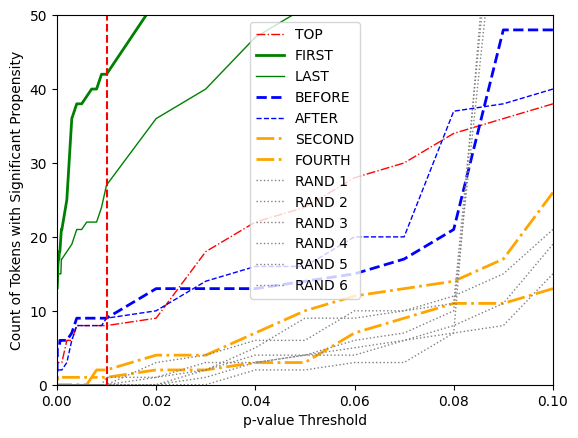

In [13]:
if do_parametric_studies:
    stat_type = 'p_value'
    num_propensity_tokens_p_value = compile_threshold_parametic_data(stat_type, use_both_thresholds=False)
    print("This plot uses both p_value and Bayes Factor.")
    plot_threshold_parametric_data(stat_type, 
                                   num_propensity_tokens_p_value)

Parametric Study of p_value
	Compiling MIDDLE
	Compiling TOP
	Compiling FIRST
	Compiling LAST
	Compiling BEFORE
	Compiling AFTER
	Compiling SECOND
	Compiling FOURTH
	Compiling RAND 1
	Compiling RAND 2
	Compiling RAND 3
	Compiling RAND 4
	Compiling RAND 5
	Compiling RAND 6
This plot uses the p_value threshold only.


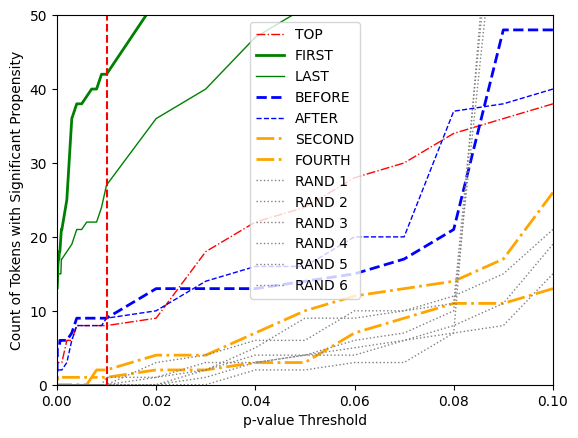

In [14]:
if do_parametric_studies:
    stat_type = 'p_value'
    num_propensity_tokens_p_value = compile_threshold_parametic_data(stat_type) 
    print("This plot uses the p_value threshold only.")
    plot_threshold_parametric_data(stat_type, 
                                   num_propensity_tokens_p_value,  
                                   filename = 'voynich_data/outputs/F_Threshold_Parametric_p_values.png')

Parametric Study of bayes
	Compiling MIDDLE
	Compiling TOP
	Compiling FIRST
	Compiling LAST
	Compiling BEFORE
	Compiling AFTER
	Compiling SECOND
	Compiling FOURTH
	Compiling RAND 1
	Compiling RAND 2
	Compiling RAND 3
	Compiling RAND 4
	Compiling RAND 5
	Compiling RAND 6
This plot uses the Bayes Factor threshold only.


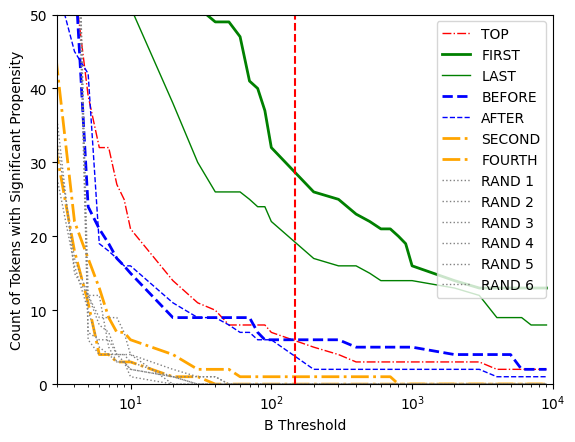

In [15]:
if do_parametric_studies:
    stat_type = 'bayes'
    num_propensity_tokens_bayes = compile_threshold_parametic_data(stat_type) 
    print("This plot uses the Bayes Factor threshold only.")
    plot_threshold_parametric_data(stat_type, 
                                   num_propensity_tokens_bayes, 
                                   filename = 'voynich_data/outputs/F_Threshold_Parametric_bayes.png')

## Create Summary DataFrames for each Cohort

### Token Propensity DataFrame

In [12]:
token_propensity_dfs = {}
print(f"smoothing: {smooth}")
print(f"Summary Dataframes, p_value_threshold= {THRESHOLDS['p_value']}, bayes_threshold={THRESHOLDS['bayes_factor']:.1f}")
N_tokens_df = pd.DataFrame(columns = ['cohort',  'N_p', 'N_p_af', 'N_p_av', 'N_b', 'N_b_af', 'N_b_av',  'N_either', 'N_both'])

for cohort in cohorts_with_randoms:
    if cohort == 'MIDDLE':
        continue
    token_propensity_dfs[cohort] = compile_token_propensity_df(cohort, 
                                                               reference_cohort, 
                                                               THRESHOLDS['p_value'], 
                                                               THRESHOLDS['bayes_factor'])
    df = token_propensity_dfs[cohort]
    print(f"DEBUG {cohort}:  {len(df)}")
    N_p = len(df[ df['sig_p_value']])
    N_p_af =  len(df[ df['sig_p_value'] & (df['propensity']>0) ])
    N_p_av =  len(df[ df['sig_p_value'] & (df['propensity']<0) ])
    N_b = len(df[ df['sig_BF']])
    N_b_af =  len(df[ df['sig_BF'] & (df['propensity']>0) ])
    N_b_av =  len(df[ df['sig_BF'] & (df['propensity']<0) ])
    N_either =  len(df[ df['sig_BF'] | df['sig_p_value'] ])
    N_both =  len(df[ df['sig_BF'] & df['sig_p_value'] ])
    N_tokens_df.loc[len(N_tokens_df)] = [cohort,
                       N_p,
                       N_p_af,
                       N_p_av,
                       N_b,
                       N_b_af,
                       N_b_av,
                       N_either,
                       N_both]
                                             
    pass
    # print(80*'-')
pass
N_tokens_df

smoothing: None
Summary Dataframes, p_value_threshold= 0.01, bayes_threshold=148.4
DEBUG TOP:  1115
DEBUG FIRST:  1115
DEBUG LAST:  1115
DEBUG BEFORE:  1115
DEBUG AFTER:  1115
DEBUG SECOND:  1115
DEBUG FOURTH:  1115
DEBUG RAND 1:  1115
DEBUG RAND 2:  1115
DEBUG RAND 3:  1115
DEBUG RAND 4:  1115
DEBUG RAND 5:  1115
DEBUG RAND 6:  1115


,cohort,N_p,N_p_af,N_p_av,N_b,N_b_af,N_b_av,N_either,N_both
0,TOP,8,6,0,7,5,0,8,7
1,FIRST,42,32,0,28,20,0,42,28
2,LAST,27,21,0,17,14,0,27,17
3,BEFORE,9,8,0,6,5,0,9,6
4,AFTER,9,9,0,3,3,0,9,3
5,SECOND,2,2,0,1,1,0,2,1
6,FOURTH,1,1,0,0,0,0,1,0
7,RAND 1,0,0,0,0,0,0,0,0
8,RAND 2,1,1,0,0,0,0,1,0
9,RAND 3,0,0,0,0,0,0,0,0


In [13]:
def extract_df(cohort, stat_type, component_type):
    print(f"'{cohort}' Compared to 'MIDDLE'")
    if component_type == 'tokens':
        df = token_propensity_dfs[cohort]
    elif component_type == 'glyphs':
       df = glyph_propensity_dfs[cohort]

    if stat_type == 'p_value':
        df = df[df['sig_p_value']]
        df.sort_values(by='p_value', ascending=False)
    elif stat_type == 'bayes':
        df = df[df['sig_BF']]        
        df.sort_values(by='bayes', ascending=False)
    elif stat_type == 'both':
        df = df[(df['sig_p_value']) & (df['sig_BF'])]
        
    print(len(df))
    return df



In [14]:
extract_df('SECOND', 'both', 'tokens')

'SECOND' Compared to 'MIDDLE'
1


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chor,4,3807,107,970,48,0.028106,0.049485,0.000164,True,True,1.8,768.928501,0.999913,0.0


In [15]:
extract_df('TOP', 'both', 'tokens')

'TOP' Compared to 'MIDDLE'
7


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,847,10,0.047281,0.011806,8.946149e-09,True,True,0.2,22026.465795,8.946149e-09,0.0
chy,3,3807,72,847,5,0.018913,0.005903,1.266470e-03,True,True,0.3,194.413453,1.266470e-03,0.0
shol,4,3807,53,847,28,0.013922,0.033058,3.568536e-05,True,True,2.4,3514.458801,9.999861e-01,0.0
chaiin,6,3807,26,847,0,0.006830,0.000000,3.014110e-03,True,True,0.0,331.772920,3.014110e-03,0.0
kchy,4,3807,25,847,0,0.006567,0.000000,3.770810e-03,True,True,0.0,265.195043,3.770810e-03,0.0
shor,4,3807,23,847,20,0.006042,0.023613,4.332600e-07,True,True,3.9,22026.465795,9.999999e-01,0.0
chcphy,6,3807,1,847,3,0.000263,0.003542,1.550233e-03,True,True,13.5,153.173337,9.999150e-01,0.0


In [16]:
extract_df('FIRST', 'both', 'tokens')

'FIRST' Compared to 'MIDDLE'
28


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,998,10,0.047281,0.010020,2.965859e-11,True,True,0.2,22026.465795,2.965859e-11,0.0
chor,4,3807,107,998,7,0.028106,0.007014,1.861640e-06,True,True,0.2,22026.465795,1.861640e-06,0.0
s,1,3807,75,998,4,0.019701,0.004008,1.964432e-05,True,True,0.2,12288.718464,1.964432e-05,0.0
chy,3,3807,72,998,1,0.018913,0.001002,1.072737e-07,True,True,0.1,22026.465795,1.072737e-07,0.0
cthy,4,3807,53,998,0,0.013922,0.000000,8.386267e-07,True,True,0.0,22026.465795,8.386267e-07,0.0
sho,3,3807,46,998,28,0.012083,0.028056,5.337535e-05,True,True,2.3,2382.238642,9.999786e-01,0.0
chey,4,3807,46,998,0,0.012083,0.000000,5.382892e-06,True,True,0.0,22026.465795,5.382892e-06,0.0
cho,3,3807,38,998,1,0.009982,0.001002,4.963764e-04,True,True,0.1,815.194158,4.963764e-04,0.0
cthol,5,3807,36,998,1,0.009456,0.001002,8.021052e-04,True,True,0.1,507.035519,8.021052e-04,0.0


In [17]:
extract_df('LAST', 'both', 'tokens')


'LAST' Compared to 'MIDDLE'
17


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,777,1,0.047281,0.001287,1.789866e-15,True,True,0.0,22026.465795,1.789866e-15,0.0
daiin,5,3807,178,777,59,0.046756,0.075933,2.350086e-04,True,True,1.6,538.964332,9.998651e-01,0.0
chor,4,3807,107,777,2,0.028106,0.002574,6.608707e-08,True,True,0.1,22026.465795,6.608707e-08,0.0
chy,3,3807,72,777,2,0.018913,0.002574,4.614725e-05,True,True,0.1,6710.553606,4.614725e-05,0.0
shol,4,3807,53,777,0,0.013922,0.000000,1.858451e-05,True,True,0.0,22026.465795,1.858451e-05,0.0
sho,3,3807,46,777,0,0.012083,0.000000,7.903051e-05,True,True,0.0,12653.341099,7.903051e-05,0.0
chey,4,3807,46,777,1,0.012083,0.001287,8.300830e-04,True,True,0.1,490.133972,8.300830e-04,0.0
dy,2,3807,28,777,28,0.007355,0.036036,1.542011e-11,True,True,4.9,22026.465795,1.000000e+00,0.0
dar,3,3807,23,777,15,0.006042,0.019305,1.089064e-04,True,True,3.2,1324.780274,9.999692e-01,0.0


In [18]:
extract_df('BEFORE', 'both', 'tokens')


'BEFORE' Compared to 'MIDDLE'
6


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,349,3,0.047281,0.008596,4.677319e-05,True,True,0.2,5751.381813,0.000047,0.0
chor,4,3807,107,349,0,0.028106,0.000000,4.775047e-05,True,True,0.0,20942.200290,0.000048,0.0
s,1,3807,75,349,19,0.019701,0.054441,8.424169e-05,True,True,2.8,1645.754299,0.999973,0.0
dy,2,3807,28,349,23,0.007355,0.065903,4.773959e-15,True,True,9.0,22026.465795,1.000000,0.0
dam,3,3807,7,349,5,0.001839,0.014327,5.220567e-04,True,True,7.8,377.795542,0.999946,0.0
qotaiin,7,3807,2,349,4,0.000525,0.011461,4.004931e-05,True,True,21.8,5089.788084,0.999999,0.0


In [19]:
extract_df('AFTER', 'both', 'tokens')


'AFTER' Compared to 'MIDDLE'
3


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
dchol,5,3807,3,278,6,0.000788,0.021583,1.210362e-07,True,True,27.4,22026.465795,1.000000,0.0
oteey,5,3807,3,278,3,0.000788,0.010791,1.474609e-03,True,True,13.7,161.412632,0.999921,0.0
sol,3,3807,1,278,3,0.000263,0.010791,6.081986e-05,True,True,41.1,3771.598637,0.999999,0.0


In [20]:
extract_df('FOURTH', 'p_value', 'tokens')


'FOURTH' Compared to 'MIDDLE'
1


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chor,4,3807,107,691,9,0.028106,0.013025,0.006402,True,False,0.5,35.853655,0.006402,0.0


In [21]:
file_path = 'voynich_data/outputs/token_propensity_dfs.pkl'
store_pkl(token_propensity_dfs, file_path) 

In [29]:
cohort_title_dict = {
'ALL':'All in Corpus',
'MIDDLE':'Middle Positions',
'TOP':'Top Lines of Paragraphs',
'FIRST': 'First Position on a Line',
'SECOND': 'Second Position on a Line',
'THIRD': 'Third Position on a Line',
'FOURTH': 'Fourth Position on a Line',
'BEFORE': 'Immediately Before a Drawing',
'AFTER':'Immediately After a Drawing',
'LAST': 'Last Position on a Line',
'RAND 1':'Random Tokens Cohort',
'RAND 2':'Random Tokens Cohort', 
'RAND 3':'Random Tokens Cohort',
'RAND 4':'Random Tokens Cohort',
'RAND 5':'Random Tokens Cohort',
'RAND 6':'Random Tokens Cohort',
}    

def filter_and_sort_dataframe(df, propensity_col, sig_p_value_col, sig_BF_col):
    # Filter rows where at least one of sig_p_value or sig_BF is True
    filtered_df = df[(df[sig_p_value_col]) & (df[sig_BF_col])]
    # filtered_df = df[(df[sig_p_value_col])]

    # Splitting the DataFrame based on propensity values
    df_greater_than_zero = filtered_df[filtered_df[propensity_col] > 1].sort_values(by=propensity_col, ascending=False)
    df_less_than_zero = filtered_df[filtered_df[propensity_col] < 1].sort_values(by=propensity_col, ascending=True)

    # Concatenating the two DataFrames
    result_df = pd.concat([df_greater_than_zero, df_less_than_zero])

    return result_df

def display_cohort_tendency_summary(cohort: str, component:str, stat_type:str, file_name: str = None, width:int=None, height:int=None):
    if component == 'tokens':
        df = token_propensity_dfs[cohort].sort_values(by='propensity', ascending=False)
        table_title = f"Positional Tendency Tokens<br>{cohort_title_dict[cohort]}"
        num_tokens_in_target = pmfs_by_c[cohort].total_count
        num_tokens_in_ref = pmfs_by_c[reference_cohort].total_count
        component_text = 'Tokens'
        
    elif component == 'glyphs':
        df = glyph_propensity_dfs[cohort].sort_values(by='propensity', ascending=False)
        table_title = f"Positional Tendency Glyphs<br>{cohort_title_dict[cohort]}"
        num_tokens_in_target = len(corpus_by_c[cohort].glyphs_df())
        num_tokens_in_ref = len(corpus_by_c[reference_cohort].glyphs_df())
        component_text = 'Glyphs'
        pass
    pass

    df = filter_and_sort_dataframe(df,'propensity', 'sig_p_value', 'sig_BF')
    # display_stat_type = 'BOTH'
        
    
    html_top = """
<html>
<head>
    <style>
        h3 {
            margin-left: auto;
            margin-right: auto;
        }
        table {
            border: 3px solid black;
            border-collapse: collapse;
            margin-left: auto;
            margin-right: auto;
        }

        th, td {
            border: 1px solid black;
            text-align: center;
        }

       .header-row {
            background-color: #7AA4F8;
        }     
        table td, table th {
            padding-left: 5px;
            padding-right: 5px;
        }
        
        tbody tr:nth-child(even) {
            background-color: #FEEFC2; /*#FFFFD9; light beige for odd rows */
        }

        tbody tr:nth-child(odd) {
            background-color: white; /* white for even rows */
        }
    </style>
</head>
<body>"""
    html_bottom = """
</body>
</html>"""
    html = ''
    # # Start the HTML table
    # html += f"<h2>{table_title}</h2>\n"
    # html += f"Reference Cohort: {reference_cohort}<br>\n"
    # html += f"Total Count in Reference Cohort: {num_tokens_in_ref}<br>\n"
    # html += f"Total Count in Target Cohort: {num_tokens_in_target}<br>\n"
    # html += f"Total Count Selected: {len(df)}\n"
    html_table_top = """
<table style='width:600px'>
    <tr>
        <th class='header-row' colspan=1 rowspan=2 style='text-align: center;'>Tilt</th>
        <th class='header-row' colspan=2 style='text-align: center;'>Token</th>
        <th class='header-row' colspan=2 style='text-align: center;'>Counts</th>
        <th class='header-row' colspan=3 style='text-align: center;'>Stats</th>
    </tr>
    <tr>
        <th class='header-row' >Voynichese</th>
        <th class='header-row' >Eva-</th>
        <th class='header-row' >expected</th>
        <th class='header-row' >observed</th>
        <th class='header-row' >Propensity</th>
        <th class='header-row' ><i>p</i>-value</th>
        <th class='header-row' ><i>log(B)</i></th>
    </tr>"""    
    html_1 = html_table_top
    # html_2 = html_table_top
    num_affinitive = len(df[df['propensity'] >= 1])
    num_aversive = len(df[df['propensity'] < 1])
    
    color = 'black' 
    # Fill the table rows
    i=-1
    for index, row in df.iterrows(): 
        i += 1
        propensity = row['propensity']
        # ln_propensity = np.log(propensity)
        # if propensity < 1:
        #     continue
        # voynichese_value = display_voynichese(text=index, render=False)

        prob_ref= row['p_ref']
        p_value = row['p_value']
        prob_x = row['p_x']
        N_x = row['N_x']
        
        observed_count = int(row['n_x'])
        expected_count =  int(np.round(prob_ref * num_tokens_in_target))
        # expected_count =  prob_ref * num_tokens_in_target
        # propensity = f"{propensity:.1f}" if observed_count > 0 else '&infin;'
        bayes = row['bayes']
        bayes = f"{np.log(bayes):.1f}" if bayes > 0 else '0'
        if bayes=='10.0':
            bayes = '>10'
            

        starp = starb = ''
        if not row['sig_p_value']:
            starp = '*'
        if i == 0:
            color = 'green'
            html_1 += f"""
<tr>
    <td rowspan={num_affinitive} style="background-color:white;color:{color};"><b>Affinitive</b></td>"""
            pass            
        elif i == num_affinitive:
            color = 'red'
            html_1 += f"""
<tr style="border-top: 3px solid black;">
    <td rowspan={num_aversive} style="background-color:white;color:{color};"><b>Aversive</b></td>"""
        else:
            html_1 += f"""
<tr>"""
            pass
        
        voynichese_value = display_voynichese(text=index, color=color, render=False)
    #     html_1 += f"""            
    # <td style='color:{color};'>{voynichese_value}</td>
        html_1 += f"""            
    <td>{voynichese_value}</td>
    <td>{index}</td>
    <td>{expected_count}</td>
    <td>{observed_count}</td>
    <td>{propensity:.1f}</td>
    <td>{p_value:.6f}{starp}</td>
    <td>{bayes}{starb}</td>
</tr>"""
            

    html_1 += """
</table>"""
    html += html_1


    # Display the HTML table
    display(HTML(html))
    if file_name:
        current_dir = os.getcwd()
        print(f"current_dir = {current_dir}")
        html_filename = file_name + '.html'
        absolute_html_file_path = os.path.join(current_dir, html_filename)
        png_filename = file_name + '.png'
        absolute_png_file_path = os.path.join(current_dir, png_filename)
        with open(html_filename, 'w') as file:
            file.write(html_top + html + html_bottom)
            print(f"Wrote {html_filename}")
        print(f"absolute_html_file_path = {absolute_html_file_path}")
        render_html_to_image(absolute_html_file_path, absolute_png_file_path, width=width, height=height+129, crop=True)



In [30]:
display_cohort_tendency_summary('TOP', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_TOP_bayes', width=630, height=500)
display_cohort_tendency_summary('FIRST', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_FIRST_bayes', width=630, height=1000)
display_cohort_tendency_summary('LAST', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_LAST_bayes', width=630, height=1000)
display_cohort_tendency_summary('BEFORE', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_BEFORE_bayes', width=630, height=500)
display_cohort_tendency_summary('AFTER', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_AFTER_bayes', width=630, height=500)
display_cohort_tendency_summary('SECOND', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_SECOND_bayes', width=630, height=500)
display_cohort_tendency_summary('FOURTH', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_FOURTH_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 1', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND1_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 2', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND2_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 3', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND3_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 4', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND4_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 5', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND5_bayes', width=630, height=500)
display_cohort_tendency_summary('RAND 6', 'tokens', 'bayes', 'voynich_data/outputs/T_token_propensities_RAND6_bayes', width=630, height=500)

current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_TOP_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_TOP_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_TOP_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_FIRST_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST_bayes.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_LAST_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_LAST_bayes.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_LAST_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_BEFORE_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_BEFORE_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_BEFORE_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_AFTER_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_AFTER_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_AFTER_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_SECOND_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_SECOND_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_SECOND_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_FOURTH_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FOURTH_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FOURTH_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND1_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND1_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND1_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND2_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND2_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND2_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND3_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND3_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND3_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND4_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND4_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND4_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND5_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND5_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND5_bayes.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND6_bayes.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND6_bayes.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND6_bayes.png'


In [31]:
display_cohort_tendency_summary('TOP', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_TOP', width=630, height=500)
display_cohort_tendency_summary('FIRST', 'tokens', 'p_value', 'voynich_data/outputs/CUTOFF_T_token_propensities_FIRST', width=630, height=1600)
display_cohort_tendency_summary('LAST', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_LAST', width=630, height=1000)
display_cohort_tendency_summary('BEFORE', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_BEFORE', width=630, height=500)
display_cohort_tendency_summary('AFTER', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_AFTER', width=630, height=500)
display_cohort_tendency_summary('SECOND', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_SECOND', width=630, height=500)
display_cohort_tendency_summary('FOURTH', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_FOURTH', width=630, height=500)
display_cohort_tendency_summary('RAND 1', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND1', width=630, height=500)
display_cohort_tendency_summary('RAND 2', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND2', width=630, height=500)
display_cohort_tendency_summary('RAND 3', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND3', width=630, height=500)
display_cohort_tendency_summary('RAND 4', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND4', width=630, height=500)
display_cohort_tendency_summary('RAND 5', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND5', width=630, height=500)
display_cohort_tendency_summary('RAND 6', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_RAND6', width=630, height=500)

current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_TOP.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_TOP.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_TOP.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/CUTOFF_T_token_propensities_FIRST.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/CUTOFF_T_token_propensities_FIRST.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/CUTOFF_T_token_propensities_FIRST.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_LAST.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_LAST.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_LAST.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_BEFORE.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_BEFORE.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_BEFORE.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_AFTER.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_AFTER.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_AFTER.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_SECOND.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_SECOND.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_SECOND.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_FOURTH.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FOURTH.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FOURTH.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND1.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND1.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND1.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND2.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND2.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND2.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND3.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND3.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND3.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND4.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND4.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND4.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND5.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND5.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND5.png'


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_RAND6.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND6.html
Visible Content Height: 490
Total Document Width: 630
Total Document Height: 490
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_RAND6.png'


In [32]:
display_cohort_tendency_summary('FIRST', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_FIRST', width=630, height=2000)


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_FIRST.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST.png'


In [30]:
display_cohort_tendency_summary('FIRST', 'tokens', 'p_value', 'voynich_data/outputs/T_token_propensities_FIRST', width=630, height=2000)


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/T_token_propensities_FIRST.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST.html
Visible Content Height: 940
Total Document Width: 630
Total Document Height: 940
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/T_token_propensities_FIRST.png'
